In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
#group data:
groups = 2

df = pd.read_csv("research_reactor(d).csv")
RR_kai_g = df['kai'].to_numpy()[0:2]
RR_nu_g = df['nu'].to_numpy()[0:2]
RR_sigma_fg = df['sigma_f'].to_numpy()[0:2]
RR_sigma_tg = df['sigma_t'].to_numpy()[0:2]
RR_sigma_s_togfromg=df.iloc[0:groups,5:5+groups].to_numpy() 

h2ob_kai_g = df['kai'].to_numpy()[2:4]
h2ob_nu_g =  df['nu'].to_numpy()[2:4]
h2ob_sigma_fg = df['sigma_f'].to_numpy()[2:4]
h2ob_sigma_tg = df['sigma_t'].to_numpy()[2:4]
h2ob_sigma_s_togfromg=df.iloc[2:4,5:5+groups].to_numpy() 

h2oc_kai_g = df['kai'].to_numpy()[4:6]
h2oc_nu_g =  df['nu'].to_numpy()[4:6]
h2oc_sigma_fg = df['sigma_f'].to_numpy()[4:6]
h2oc_sigma_tg = df['sigma_t'].to_numpy()[4:6]
h2oc_sigma_s_togfromg=df.iloc[4:6,5:5+groups].to_numpy()



In [13]:

#this section defines geometry
# an array of midpoint co ordinates of each mesh is genrated and corresponding sigma arrays containing cross secitons are also generated
# this problem is taken from Sood et. el. 2003. which is named as  URRd-H2Oc(1)-2-0-ISLC in the paper

mesh_number = 100
width_of_region = np.array([ 0.341011, 0.751023])
mesh_width = width_of_region/mesh_number

RR_region_points = np.arange(mesh_width[0]/2, width_of_region[0] , mesh_width[0])
x_i = RR_region_points.copy()
h_i = np.ones(len(RR_region_points))*mesh_width[0]
total_width = width_of_region[0]+width_of_region[1]
I_rr = len(RR_region_points)


h2ob_region_points = np.arange(width_of_region[0]+mesh_width[1]/2,total_width, mesh_width[1])
x_i = np.append(x_i,h2ob_region_points)
h_i = np.append(h_i,np.ones(len(RR_region_points))*mesh_width[1])
I_h2ob = len(h2ob_region_points)

I = len(x_i)

kai_gi =np.zeros((groups,len(x_i)))
nu_gi = np.zeros((groups,len(x_i)))
sigma_f_gi = np.zeros((groups,len(x_i)))
sigma_t_gi=np.zeros((groups,len(x_i)))
sigma_s_togfromg_i= np.zeros((groups,groups,len(x_i))) ##(destination, source, position)

for i in range(I):
    if(i<I_rr):
        kai_gi[:,i] = RR_kai_g
        nu_gi[:,i]  = RR_nu_g
        sigma_f_gi[:,i]  = RR_sigma_fg
        sigma_t_gi[:,i] = RR_sigma_tg
        sigma_s_togfromg_i[:,:,i]  = RR_sigma_s_togfromg
    
    else:
        kai_gi[:,i] = h2oc_kai_g
        nu_gi[:,i]  = h2oc_nu_g
        sigma_f_gi[:,i]  = h2oc_sigma_fg
        sigma_t_gi[:,i] = h2oc_sigma_tg
        sigma_s_togfromg_i[:,:,i]  = h2oc_sigma_s_togfromg


In [14]:
#tabuchi_yamamoto quadrature set
polar =3



sintheta_p = np.array([.166648, .537707, .932954])
theta_p = (np.arcsin(sintheta_p))
w_p = 2*(np.array([0.046233, 0.283619, 0.670148]))

mu_pplushalf = np.zeros(polar+1)

for i in range(polar+1):
    
    mu_pplushalf[i] = -1+sum(w_p[0:i])
#azimuthal angle 

azim = 64
w_b = 2*np.pi / azim
beta_b = np.arange(w_b/2,2*np.pi, w_b )

#exploiting symmetry
w_b = np.ones(azim)*w_b*2
azim = int(azim/2)

left = 1
right = 0


In [15]:
#transport sweep
def sweep_1d(q_i, psi_left, sigma_t):

    I = len(x_i)
    alpha_right = 1 #reflecting at righht
    alpha_left = 1 #reflecting at left
    


    #flux =  q_i/ sigma_t
    flux = np.zeros(I)
    del_psi = np.zeros((azim,polar))
    psi_boun = np.zeros((2,int(azim/2),polar))
    psi_avg = np.zeros((azim,polar))
    psi_in = np.zeros((azim,polar))
    psi_in[0:int(azim/2)] = psi_left

    #from left to right
    for i in range(I):
        
        for p in range(int(polar)):
            for b in range(int(azim/2)):
                
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p] 
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]
        
           
    
    psi_in[int(azim/2):azim, :] = alpha_right* np.flipud(psi_in[0:int(azim/2),:])
    psi_boun[right] = psi_in[int(azim/2):azim, :]
    #psi_in[int(azim/2):azim, :] = 0
    #print(psi_in)
    
    
    
    #right to left
    for i in reversed(range(I)):
        
        for p in range(polar):
            for b in range(int(azim/2),azim):
                length = abs(h_i[i]/(sintheta_p[p])/np.cos(beta_b[b]))
                del_psi[b,p] = (psi_in[b,p] - q_i[i]/(4*np.pi*sigma_t[i]))*(1-np.exp(-sigma_t[i]*length))
                psi_avg[b,p] = q_i[i]/(4*np.pi*sigma_t[i]) + del_psi[b,p]/(sigma_t[i]*length)
                flux[i] = flux[i] + w_b[b]*w_p[p]*psi_avg[b,p]
                #flux[i] = flux[i] + 1/(sigma_t[i]*length) * del_psi[b,p] *w_b[b]*w_p[p]
                psi_in[b,p] = psi_in[b,p] - del_psi[b,p]
    
    psi_boun[left] = np.flipud(psi_in[int(azim/2):azim])*alpha_left ##boundary condiiton at the left
    

    return flux,psi_boun

In [16]:



def multi_eigen_solver():
    keff = 1
    keff_new = 1

    psi_boun_g = np.zeros((groups,2,int(azim/2),polar))
    psi_boun_g_new = np.zeros((groups,2,int(azim/2),polar))

    flux_g = np.ones((groups,I)) 
    flux_new_g = np.zeros((groups,I))
    res_keff = np.inf
    res_flux= np.inf
    res_psi = np.inf
    

    fission_source_gi = kai_gi*sum(nu_gi*sigma_f_gi*flux_g)
    
    q_gi = np.ones((groups,I))
    fission_source_new_gi = np.zeros((groups,I))
    sweeps = 0

    while(res_keff>10**-7):
        q_ind_gi = fission_source_gi/keff
        
        for to_g in range(groups):
            for from_g in range(groups):
                if(to_g != from_g):
                    q_ind_gi[to_g] = q_ind_gi[to_g] + flux_g[from_g] * sigma_s_togfromg_i[to_g,from_g]
        
        for g in range(groups):
            res_flux = np.inf
            while(res_flux > 10**-7 ):
                q_gi[g] = q_ind_gi[g] + sigma_s_togfromg_i[g,g] * flux_g[g]
                
                flux_new_g[g,:] , psi_boun_g_new[g,:,:,:]= sweep_1d(q_gi[g], psi_boun_g[g,left],sigma_t_gi[g])
                
                sweeps = sweeps+1

                res_flux = np.amax(abs((flux_new_g[g]-flux_g[g])/flux_new_g[g]))
                #print(res_flux)
                #res_psi = np.amax(abs((psi_boun_g_new[g]-psi_boun_g[g])/psi_boun_g_new[g]))
                
                
                flux_g[g,:] = flux_new_g[g,:]
                psi_boun_g[g,:] = psi_boun_g_new[g,:]
            
        
        
        fission_source_new_gi = kai_gi*sum(nu_gi*sigma_f_gi*flux_g)
        keff_new = keff* sum(sum(fission_source_new_gi*h_i))/sum(sum(fission_source_gi*h_i))
        print('keff',keff_new, 'with', sweeps,'sweeps')

        res_keff = abs(keff-keff_new)
        #print(res_keff)
        keff = keff_new
        fission_source_gi = fission_source_new_gi

        
    return keff_new, flux_g, psi_boun_g

keff,flux_g, psi_boun_g = multi_eigen_solver()




keff 1.0946770811376594 with 1334 sweeps
keff 1.0001138858340668 with 2573 sweeps
keff 1.0000346460559595 with 3025 sweeps
keff 1.0000076697213716 with 3319 sweeps
keff 1.0000055163427055 with 3393 sweeps
keff 1.0000052724426087 with 3404 sweeps
keff 1.0000052018698737 with 3407 sweeps


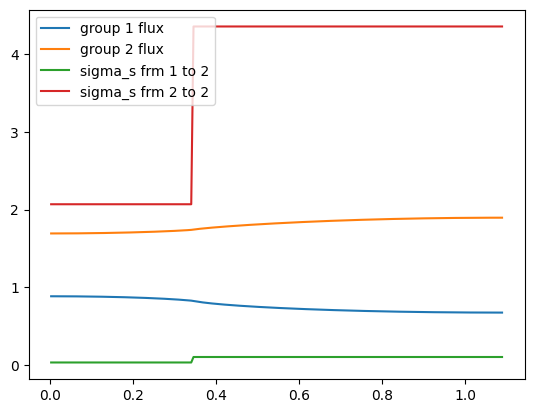

In [17]:
plt.plot(x_i, flux_g[0], label = "group 1 flux")
plt.plot(x_i, flux_g[1], label = "group 2 flux")

plt.plot(x_i, sigma_s_togfromg_i[1,0] , label = 'sigma_s frm 1 to 2')
plt.plot(x_i, sigma_s_togfromg_i[1,1] , label = "sigma_s frm 2 to 2")
plt.legend()
plt.show()